# W2V revisited

Про LR не говорит ничего. Обновление весов происходит сразу, но очень разреженно ($20000*1000$ - датасет, а обновление затрагивает $2m+1$ слов как максимум). На практике $m=5..10$

Инициализация W2V происходит от взятия равномерно маленьких величин между двумя мелкими же константами.

__Проблема:__

$$ p(o \:|\: c) = \frac{\exp(u_o^Tv_c)}{\sum_{w=1}^V \exp(u_w^Tv_c)} $$

Числитель-то изи, а знаменатель по всему словарю для _каждого окна_.

__Решение:__ тренируется логрегрессия - числитель - для максимизации правдоподобия. А в знаменатель суются _несколько_ рандомных слов, и считается, что они в контексте не возникают вместе. Это и есть __Negative Sampling__.

##### Итого

$$ J(\theta) = \sum_{t=1}^T J_t(\theta) $$

$$ J_t(\theta) = log \sigma (u_o^Tv_c) + \sum_{i=1}^k \mathbb{E}_{ j \sim P(w) } [ log \: \sigma (-u_j^Tv_c) ] = $$

$$ = log\: \sigma (u_o^Tv_c) + \sum_{j \sim P(w)} [ log \: \sigma (-u_j^Tv_c) ] $$

, здесь $t$ - окно, с которым ты идешь по корпусу слов. 

Первая часть лосса - мы поднимаем вероятность взаимного возникновения слов. Вторая часть - мы берем несколько слов и минимизируем вероятность их взаимного возникновения. Берем, точнее, что-то типа $k=10$ слов.

$$ P(w) = \frac{U(w)^{3/4}}{Z} $$

$U(w)$ - распределение униграмм, 3/4 - хак, чтобы не селектить только "the" или "a". __Что такое Z?!__

## Window-based co-occurence matrix

Corpus:

> I like deep learning.

> I like NLP.

> I enjoy flights.

| counts   | I | like | enjoy | deep | learning | NLP | flights | . |
|:--------:|:-:|:----:|:-----:|:----:|:--------:|:---:|:-------:|:-:|
| I        | 0 | 2    | 1     | 0    | 0        | 0   | 0       | 0 |
| like     | 2 | 0    | 0     | 1    | 0        | 1   | 0       | 0 |
| enjoy    | 1 | 0    | 0     | 0    | 0        | 0   | 1       | 0 |
| deep     | 0 | 1    | 0     | 0    | 1        | 0   | 0       | 0 |
| learning | 0 | 0    | 0     | 1    | 0        | 0   | 0       | 1 |
| NLP      | 0 | 1    | 0     | 0    | 0        | 0   | 0       | 1 |
| flights  | 0 | 0    | 1     | 0    | 0        | 0   | 0       | 1 |
| .        | 0 | 0    | 0     | 0    | 1        | 1   | 1       | 0 |

Взял потом такой SVD, ну и ты понял. От матрицы $U$ построил первые 2 компоненты.

In [6]:
import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = ['I', 'like', 'enjoy', 'deep', 'learning', 'NLP', 'flights', '.']

In [3]:
cooccurence = np.array([
    [0,2,1,0,0,0,0,0],
    [2,0,0,1,0,1,0,0],
    [1,0,0,0,0,0,1,0],
    [0,1,0,0,1,0,0,0],
    [0,0,0,1,0,0,0,1],
    [0,1,0,0,0,0,0,1],
    [0,0,0,0,0,0,0,1],
    [0,0,0,0,1,1,1,0],
])

In [4]:
U, s, Vh = la.svd(cooccurence, full_matrices=False)

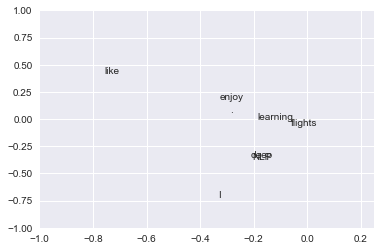

In [14]:
for i in range(len(words)):
    plt.text(U[i,0], U[i,1], words[i])
plt.xlim((-1, 0.25));
plt.ylim((-1, 1));

Стоп-слова влияют слишком сильно?

1. Выбрось их
2. Или замени на $min(100, x)$

Ну и еще много всего. Играешься с этой матрицей, и все становится лучше. Прикол в том, что так игрались в 2005, лол. Но результаты были классные! 

`See: "An Improved Model of Semantic Similarity Based on Lexical Co-Occurence, Rodhe, 2005"`

Дорого считать.

Более сложная морфология в других языках является мотиватором спуститься на уровень символов.

<img src="../img/cbvsdp.png" width="60%">

# GloVe - попытка соединить два мира

$$ J(\theta) = \frac{1}{2}\sum_{i,j=1}^{W} f(P_{ij})(u_i^Tv_j - logP_{ij})^2 $$

, здесь $P_{ij}$ - сколько раз $i$-ое и $j$-ое слова встретились, то есть элемент из матрицы встречаемости выше. Стараемся минимизировать дистанцию между скалярным произведением и log от количества.

$f$ позволяет как-то перевзвесить коэффициенты в $P$, например, урезать стоп-слова: $min(P_{ij}, 100)$. 

* Быстро тренируется.
* Скейлится на большой корпус.
* Круто себя показывает даже на мелких корпусах или мелких размерах выходных векторов.

`See: "Pennington, Socher, Manning (2014)"`

__Интуиция:__ Word2Vec пытается выучить встречаемости в рамках одного окна. GloVe пытается выучить частоты встречаемости в общей статистике того, как эти векторы появляются. 

## Evaluating

* На метриках, статистиках и сравнении
* На реальной задаче (трудоемко, правда)

# Применение GloVe к классификации

Например, является ли слово локацией. NER.

$$ p(y|x) = \frac{exp(W_yx)}{\sum_{c=1}^C exp(W_cx)} $$

$$ W \in \mathbb{R}^{C \times d} $$

Loss: cross-entropy.

Чтобы вычислить $p(y|x)$: 

* возьмем $y$-ую строку $W$ и умножим скалярно на $x$:

$$ W_yx = \sum_{i=1}^d W_{yi}x_i = f_y $$

* Вычисляем все $f_c, c=\overline{1,C}$ 

* Нормализуем в вероятности с помощью softmax:

$$ p(y|x) = \frac{exp(f_y)}{\sum_{c=1}^C exp(f_c)} $$